In [1]:
%matplotlib inline
import os
import math
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import IPython.display as ipd

import librosa

In [2]:
data_folder = 'data_v_7_stc'

metafile = os.path.join(data_folder, 'meta.txt')
audio_folder = os.path.join(data_folder, 'audio')

In [3]:
df = pd.read_csv(metafile, sep='\t', header=None)
df.columns = ['file', 'unk1', 'unk2', 'duration', 'type']

In [4]:
df.sample(5)

,file,unk1,unk2,duration,type
1740,bg_0111_time_stretch_1.wav,office,0,1.668299,bags
417,background_0028_time_stretch_7.wav,office,0,5.061678,background
1693,bg_0099_time_stretch_3.wav,office,0,1.603855,bags
9888,tool_0241.wav,office,0,4.000000,tool
10597,tool_0950.wav,office,0,2.255375,tool


In [5]:
uniqs = df['type'].unique()

# Find file count of each type

In [6]:
rows_count = lambda df, t: len(df.loc[df['type'] == t].index)
type_freqs = {name: rows_count(df, name) for name in uniqs}

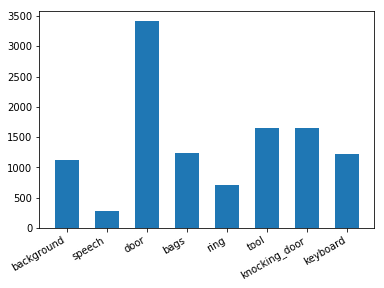

In [7]:
plt.bar(range(len(type_freqs)), list(type_freqs.values()), align='center', width=0.6)
plt.xticks(range(len(type_freqs)), list(type_freqs.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right') 
 
plt.show()

# Find average durations

In [8]:
avg_duration = lambda df, t: df.loc[df['type'] == t]['duration'].mean()
type_avg_durations = {name: avg_duration(df, name) for name in uniqs}

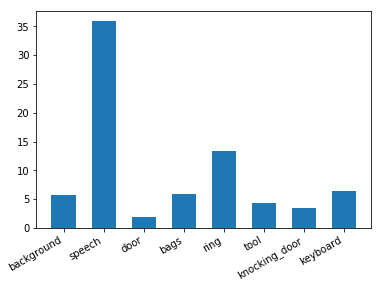

In [9]:
plt.bar(range(len(type_avg_durations)), list(type_avg_durations.values()), align='center', width=0.6)
plt.xticks(range(len(type_avg_durations)), list(type_avg_durations.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

# Find total durations

In [10]:
total_duration = lambda df, t: df.loc[df['type'] == t]['duration'].sum()
type_durations = {name: total_duration(df, name) for name in uniqs}

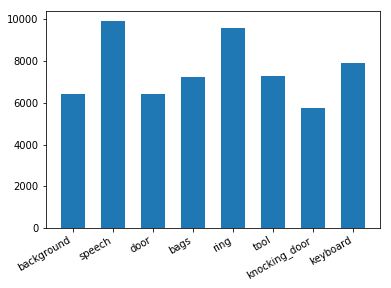

In [11]:
plt.bar(range(len(type_durations)), list(type_durations.values()), align='center', width=0.6)
plt.xticks(range(len(type_durations)), list(type_durations.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

# Analyze sounds

In [12]:
data = df.iloc[2363]
file = os.path.join(audio_folder, data['file'])
y, sr = librosa.load(file)
print(data)

file        door_0001_time_stretch_0.wav
unk1                              office
unk2                                   0
duration                         8.08376
type                                door
Name: 2363, dtype: object


#### hear difference between trimmed and given audios

In [13]:
ipd.Audio(y, rate=sr)

In [14]:
trimmed_folder = os.path.join(data_folder, 'trimmed')

In [15]:
yt, index = librosa.effects.trim(y, top_db=20)

In [16]:
ipd.Audio(yt, rate=sr)

In [17]:
print('duration decreased on %.3f sec.' % (librosa.get_duration(y) - librosa.get_duration(yt)))

duration decreased on 4.717 sec.


### Trim all data

In [18]:
trimmed_folder = os.path.join(data_folder, 'trimmed')

In [19]:
if not os.path.exists(trimmed_folder):
    os.makedirs(trimmed_folder)
    
def trim(file):
    path = os.path.join(audio_folder, file)
    y, sr = librosa.load(path)
    yt, index = librosa.effects.trim(y, top_db=20)
    new_path = os.path.join(trimmed_folder, file)
    librosa.output.write_wav(new_path, yt, sr)
    return librosa.get_duration(yt)

In [20]:
trimmed_df = pd.DataFrame(columns=['file', 'duration', 'type'])
trimmed_metafile =  os.path.join(trimmed_folder, 'meta.txt')
if os.path.exists(trimmed_metafile):
    trimmed_df = pd.read_csv(trimmed_metafile, sep='\t')
else:
    for i, row in df.iterrows():
        dur = trim(row['file'])
        trimmed_df.loc[i] = [row['file'], dur, row['type']]
    trimmed_df.to_csv(trimmed_metafile, sep='\t')

In [21]:
trimmed_df.loc[trimmed_df['type'] == 'speech'].sample(5)

,Unnamed: 0,file,duration,type
9626,9626,speech_0103.wav,5.808526,speech
9479,9479,speech_0022_slice_2.wav,59.025125,speech
9541,9541,speech_0034_slice_4.wav,60.000000,speech
9461,9461,speech_0018_slice_4.wav,60.000000,speech
9629,9629,speech_0106.wav,4.388571,speech


### Histogram of file durations

Text(0.05, 0.5, 'file count')

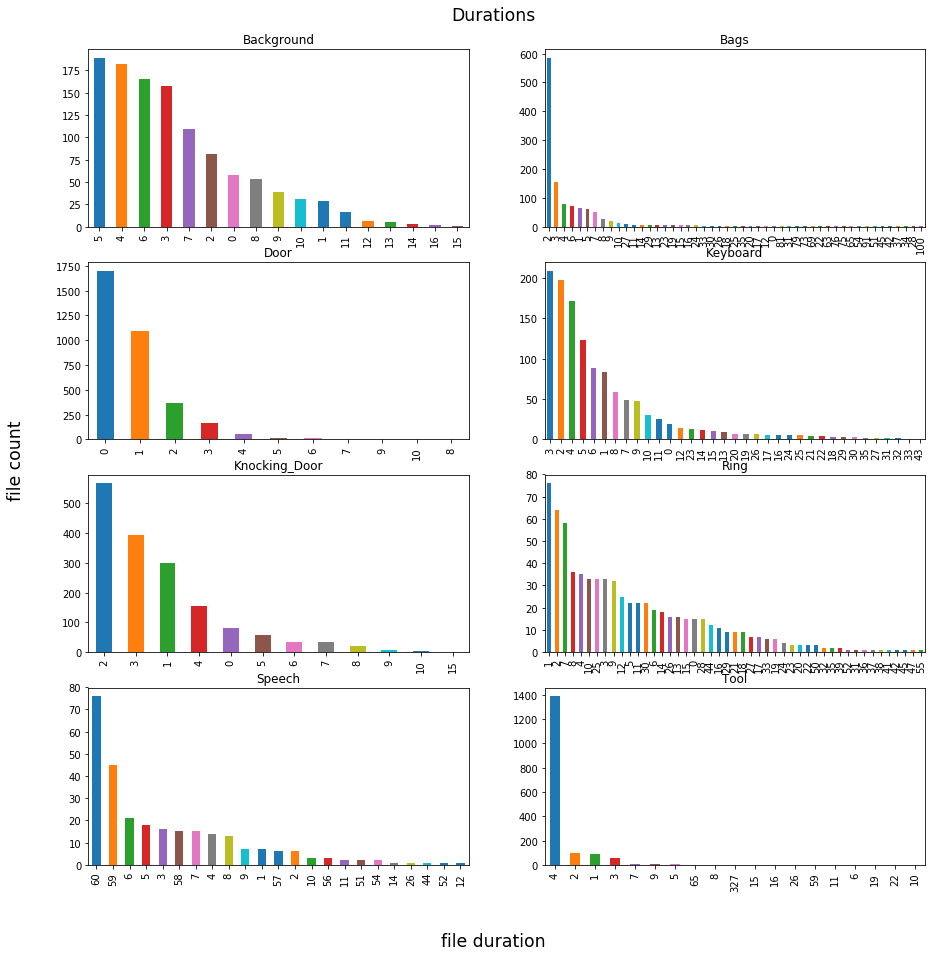

In [22]:
trimmed_df['duration'] = trimmed_df['duration'].map(lambda x: round(x))
fig, ax_rows = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

axes = [ax for row in ax_rows for ax in row]
types = trimmed_df['type'].unique()

for typ, ax in zip(types, axes):
    ax.set_title(typ.title(), fontsize='large')
    trimmed_df.loc[trimmed_df['type'] == typ]['duration'].value_counts().plot(kind='bar', ax=ax)

# set title and axis labels
plt.suptitle('Trimmed durations', y=0.92, ha='center', fontsize='xx-large')
fig.text(0.5, 0.05, 'file duration', ha='center', fontsize='xx-large')
fig.text(0.05, 0.5, 'file count', va='center', rotation='vertical', fontsize='xx-large')

Text(0.05, 0.5, 'file count')

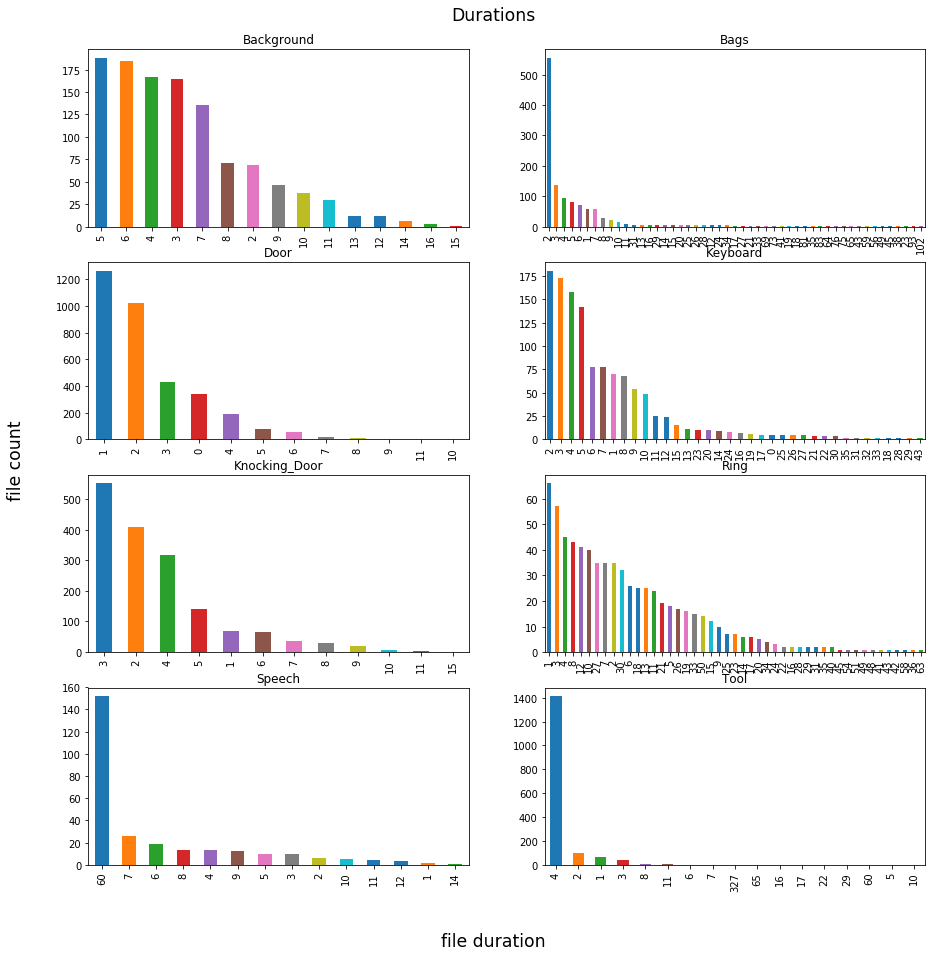

In [23]:
df['duration'] = df['duration'].map(lambda x: round(x))
fig, ax_rows = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

axes = [ax for row in ax_rows for ax in row]
types = df['type'].unique()

for typ, ax in zip(types, axes):
    ax.set_title(typ.title(), fontsize='large')
    df.loc[df['type'] == typ]['duration'].value_counts().plot(kind='bar', ax=ax)

# set title and axis labels
plt.suptitle('Durations', y=0.92, ha='center', fontsize='xx-large')
fig.text(0.5, 0.05, 'file duration', ha='center', fontsize='xx-large')
fig.text(0.05, 0.5, 'file count', va='center', rotation='vertical', fontsize='xx-large')

In [24]:
cut_folder = os.path.join(data_folder, 'cut')

In [25]:
# split background files to smaller ones with duration of 4s
def split(df, new_duration, threshold):
    to_split = df.loc[df['duration'] > threshold]
    data = []
    for row in to_split.iterrows():
        file = row[1]['file']
        y, sr = librosa.load(os.path.join(audio_folder, file))
        length = sr * new_duration
        frames = librosa.util.frame(y, frame_length=length, hop_length=length)
        for i, track in enumerate(frames.T):
            new_filename = os.path.splitext(os.path.basename(file))[0] + '_cut_' + str(i) + '.wav'
            librosa.output.write_wav(os.path.join(audio_folder, new_filename), track, sr)
            data.append({
                'file':new_filename,
                'unk1': row[1]['unk1'],
                'unk2': row[1]['unk2'],
                'duration': librosa.get_duration(track),
                'type': row[1]['type']
            })
    return data

In [26]:
threshold = 5
new_duration = 4
# split long audio files of these types
for typ in ['background', 'bags', 'keyboard', 'tool', 'speech', 'ring']:
    # insert information about new files to dataframe
    cut_data = split(df.loc[df['type'] == typ], new_duration, threshold)
    df = df.append(cut_data, ignore_index=True)
    # drop rows with duration over than threshold
    df = df.drop(df.loc[df['type'] == typ].loc[df['duration'] > threshold].index)

In [27]:
# drop rows with data over 5 sec for door and knocking_door files
for typ in ['door', 'knocking_door']:
    df = df.drop(df.loc[df['type'] == typ].loc[df['duration'] > threshold].index)

Text(0.05, 0.5, 'file count')

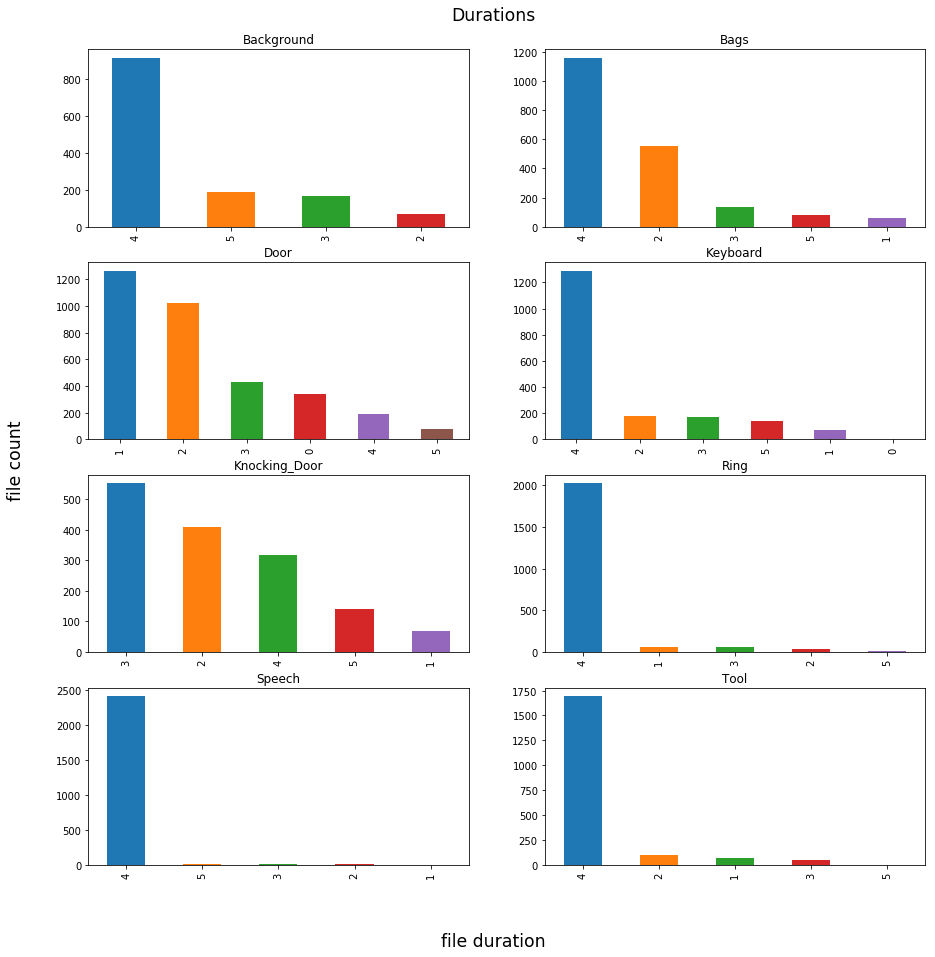

In [28]:
df['duration'] = df['duration'].map(lambda x: round(x))
fig, ax_rows = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

axes = [ax for row in ax_rows for ax in row]
types = df['type'].unique()

for typ, ax in zip(types, axes):
    ax.set_title(typ.title(), fontsize='large')
    df.loc[df['type'] == typ]['duration'].value_counts().plot(kind='bar', ax=ax)

# set title and axis labels
plt.suptitle('Durations', y=0.92, ha='center', fontsize='xx-large')
fig.text(0.5, 0.05, 'file duration', ha='center', fontsize='xx-large')
fig.text(0.05, 0.5, 'file count', va='center', rotation='vertical', fontsize='xx-large')

### Save dataframe

In [29]:
df.to_csv('newmeta.txt', sep='\t', index=False)

# Create lstm network

### 1) shuffle dataframe and create categorical column for type

In [30]:
df = df.sample(frac=1).reset_index(drop=True)

In [31]:
df.type = pd.Categorical(df.type)
df['code'] = df.type.cat.codes

### 2) create train data generator

In [35]:
def train_generator():
    for row in df.iterrows():
        data = row[1]
        file = os.path.join(audio_folder, data['file'])
        y, sr = librosa.load(file)
        
        win_length = math.ceil( len(y2)/(sr/1000)/ 25 ) # 25ms
        hop_length = math.ceil( len(y2)/(sr/1000)/ 15 ) # 15ms

        stft = librosa.core.stft(y, hop_length=hop_length, win_length=win_length)
        stft_vec = np.squeeze(np.asarray(stft))
        yield stft, data['code']

### 3) Create, compile, train model (не работает)

In [36]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed
from keras.utils import to_categorical

model = Sequential()

model.add(LSTM(32, return_sequences=True, input_shape=(None, 5)))
model.add(LSTM(8, return_sequences=True))
model.add(TimeDistributed(Dense(2, activation='sigmoid')))

print(model.summary(90))

model.compile(loss='categorical_crossentropy',
              optimizer='adam')

model.fit_generator(train_generator(), steps_per_epoch=30, epochs=10, verbose=1)

__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
lstm_5 (LSTM)                           (None, None, 32)                    4864          
__________________________________________________________________________________________
lstm_6 (LSTM)                           (None, None, 8)                     1312          
__________________________________________________________________________________________
time_distributed_3 (TimeDistributed)    (None, None, 2)                     18            
Total params: 6,194
Trainable params: 6,194
Non-trainable params: 0
__________________________________________________________________________________________
None
Epoch 1/10


NameError: name 'y2' is not defined